# Training Dynamics and Automated Metrics

Visualizes steering vector training metrics across epochs, layers, and models.

**Training Metrics** (across epochs):
- Evaluation loss (target and anti-target directions)
- Reward accuracy
- Reward margins
- Target log probabilities

**Generation Metrics** (across multipliers):
- Perplexity (log₁₀ scale)
- Propensity

In [1]:
import json
import os
import sys
from io import StringIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# Add paths for shared imports
REPO_ROOT = Path("../..").resolve()
PROJECT_ROOT = Path("..").resolve()  # 2-steering-vector-training
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(PROJECT_ROOT))

from setup.plot_config import (
    PASTEL2,
    SET2,
    set_pub_style,
    save_fig,
)

# Set paths
VECTOR_DIR = PROJECT_ROOT / "vector"
VECTOR_EVALS_DIR = PROJECT_ROOT / "vector_evals"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIGURE_DIR = OUTPUT_DIR / "figures"
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# Apply publication style
set_pub_style()

Publication style loaded (font: Arial)


## Configuration

In [2]:
# Layer configurations for different model sizes
LAYER_CONFIGS = {
    "32": {"layers": [5, 11, 13, 14, 15, 17, 23]},
    "80": {"layers": [9, 15, 21, 27, 29, 31, 33, 35, 41]},
}

# Model name to layer config mapping
SHORT_MODELS = {
    "Llama-3.1-70B-Instruct": "80",
    "Llama-3.1-8B-Instruct": "32",
}

# Display names
MODEL_DISPLAY = {
    "Llama-3.1-70B-Instruct": "Llama-3.1-70B-Instruct",
    "Llama-3.1-8B-Instruct": "Llama-3.1-8B-Instruct",
}

# Multipliers used in generation experiments
MULTIPLIERS = [
    -20,
    -10,
    -5,
    -4,
    -3,
    -2.5,
    -2,
    -1.5,
    -1,
    -0.5,
    0,
    0.5,
    1,
    1.5,
    2,
    2.5,
    3,
    4,
    5,
    10,
    20,
]

## Load Training Metrics

In [3]:
def load_training_metrics():
    """Load evaluation metrics for all model-layer combinations."""
    data = {}

    for model_name, n_layers in SHORT_MODELS.items():
        layers = LAYER_CONFIGS[n_layers]["layers"]

        for layer in layers:
            key = f"{model_name}-layer{layer}"
            metrics_file = (
                VECTOR_DIR
                / f"relationship-seeking_{model_name}"
                / f"layer{layer}"
                / "evaluation_metrics.jsonl"
            )

            if metrics_file.exists():
                with open(metrics_file, "r") as f:
                    df = pd.read_json(StringIO(f.read()), lines=True)
                # Round epoch to nearest integer
                df["epoch"] = df["epoch"].map(lambda x: int(np.ceil(x)))
                data[key] = {
                    "losses": df,
                    "metadata": {"model": model_name, "layer": layer},
                }
                print(f"Loaded {len(df)} metrics for {key}")
            else:
                print(f"Missing: {metrics_file}")

    return data


data = load_training_metrics()
print(f"\nLoaded {len(data)} model-layer combinations")

Loaded 40 metrics for Llama-3.1-70B-Instruct-layer9
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer15
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer21
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer27
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer29
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer31
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer33
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer35
Loaded 40 metrics for Llama-3.1-70B-Instruct-layer41
Loaded 40 metrics for Llama-3.1-8B-Instruct-layer5
Loaded 40 metrics for Llama-3.1-8B-Instruct-layer11
Loaded 40 metrics for Llama-3.1-8B-Instruct-layer13
Loaded 40 metrics for Llama-3.1-8B-Instruct-layer14
Loaded 40 metrics for Llama-3.1-8B-Instruct-layer15
Loaded 40 metrics for Llama-3.1-8B-Instruct-layer17
Loaded 40 metrics for Llama-3.1-8B-Instruct-layer23

Loaded 16 model-layer combinations


## Training Dynamics Plot

In [4]:
def plot_training_dynamics(data, figsize=(14, 15)):
    """
    Plot training dynamics: 4 rows (metrics) x 2 columns (models).

    Shared y-axes per row, colorbars at bottom for layer indication.
    """
    model_names = ["Llama-3.1-70B-Instruct", "Llama-3.1-8B-Instruct"]

    # Colormaps for each model
    cmaps = {
        "Llama-3.1-70B-Instruct": plt.cm.viridis,
        "Llama-3.1-8B-Instruct": plt.cm.plasma,
    }

    linestyles = {1.0: "-", -1.0: "--"}

    metrics = [
        ("loss", "Evaluation Loss"),
        ("eval_rewards/accuracies", "Reward Accuracy"),
        ("eval_rewards/margins", "Reward Margin"),
        ("eval_logps/chosen", "Target Log Prob"),
    ]

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(
        5, 2, figure=fig, height_ratios=[1, 1, 1, 1, 0.15], hspace=0.3, wspace=0.15
    )

    # Normalizers for colorbars
    norms = {}
    for model in model_names:
        layers = LAYER_CONFIGS[SHORT_MODELS[model]]["layers"]
        norms[model] = Normalize(vmin=min(layers), vmax=max(layers))

    for row_idx, (metric_key, metric_label) in enumerate(metrics):
        axes = []
        for col_idx, model in enumerate(model_names):
            # Share y-axis within row (except first row)
            if col_idx == 0:
                ax = fig.add_subplot(gs[row_idx, col_idx])
            else:
                if row_idx == 0:
                    ax = fig.add_subplot(gs[row_idx, col_idx])
                else:
                    ax = fig.add_subplot(gs[row_idx, col_idx], sharey=axes[0])
            axes.append(ax)

            layers = LAYER_CONFIGS[SHORT_MODELS[model]]["layers"]
            cmap = cmaps[model]
            norm = norms[model]
            colors = {layer: cmap(norm(layer)) for layer in layers}

            for layer in layers:
                key = f"{model}-layer{layer}"
                if key not in data:
                    continue

                df = data[key]["losses"]
                df = df.dropna(subset=["eval_rewards/chosen", "epoch"])
                df = df.sort_values("epoch")

                if metric_key == "loss":
                    for dir_name, multiplier in [("add", 1.0), ("sub", -1.0)]:
                        col = f"eval_test_dataset_{dir_name}_loss"
                        subset = df[df["eval_multiplier"] == multiplier]
                        if len(subset) > 0:
                            ax.plot(
                                subset["epoch"],
                                subset[col],
                                color=colors[layer],
                                linestyle=linestyles[multiplier],
                                linewidth=2.5,
                                alpha=0.8,
                            )
                else:
                    for mult in [1.0, -1.0]:
                        subset = df[df["eval_multiplier"] == mult]
                        if len(subset) > 0:
                            ax.plot(
                                subset["epoch"],
                                subset[metric_key],
                                color=colors[layer],
                                linestyle=linestyles[mult],
                                linewidth=2.5,
                                alpha=0.8,
                            )

            # Styling (grid/spines handled by rcParams)
            if row_idx == 0:
                ax.set_title(MODEL_DISPLAY[model])

            if row_idx == len(metrics) - 1:
                ax.set_xlabel("Epoch")

            if col_idx == 0:
                ax.set_ylabel(metric_label)
            else:
                if row_idx != 0:
                    plt.setp(ax.get_yticklabels(), visible=False)

    # Colorbars
    cbar_ax_left = fig.add_subplot(gs[4, 0])
    cbar_ax_right = fig.add_subplot(gs[4, 1])

    for cbar_ax, model in [
        (cbar_ax_left, "Llama-3.1-70B-Instruct"),
        (cbar_ax_right, "Llama-3.1-8B-Instruct"),
    ]:
        sm = ScalarMappable(cmap=cmaps[model], norm=norms[model])
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
        cbar.set_label(f"Layer ({MODEL_DISPLAY[model]})", fontstyle="italic")

        layers = LAYER_CONFIGS[SHORT_MODELS[model]]["layers"]
        cbar.set_ticks(layers)
        cbar.set_ticklabels([str(int(l)) for l in layers])

    # Legend for linestyles
    linestyle_handles = [
        Line2D(
            [0],
            [0],
            color="black",
            linestyle="-",
            linewidth=2.5,
            label=r"$\lambda = +1.0$",
        ),
        Line2D(
            [0],
            [0],
            color="black",
            linestyle="--",
            linewidth=2.5,
            label=r"$\lambda = -1.0$",
        ),
    ]

    legend = fig.legend(
        linestyle_handles,
        [h.get_label() for h in linestyle_handles],
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        title="Multiplier Direction",
    )
    legend.get_title().set_fontstyle("italic")

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, top=0.94)

    return fig

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_45509/1615722845.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: training_dynamics


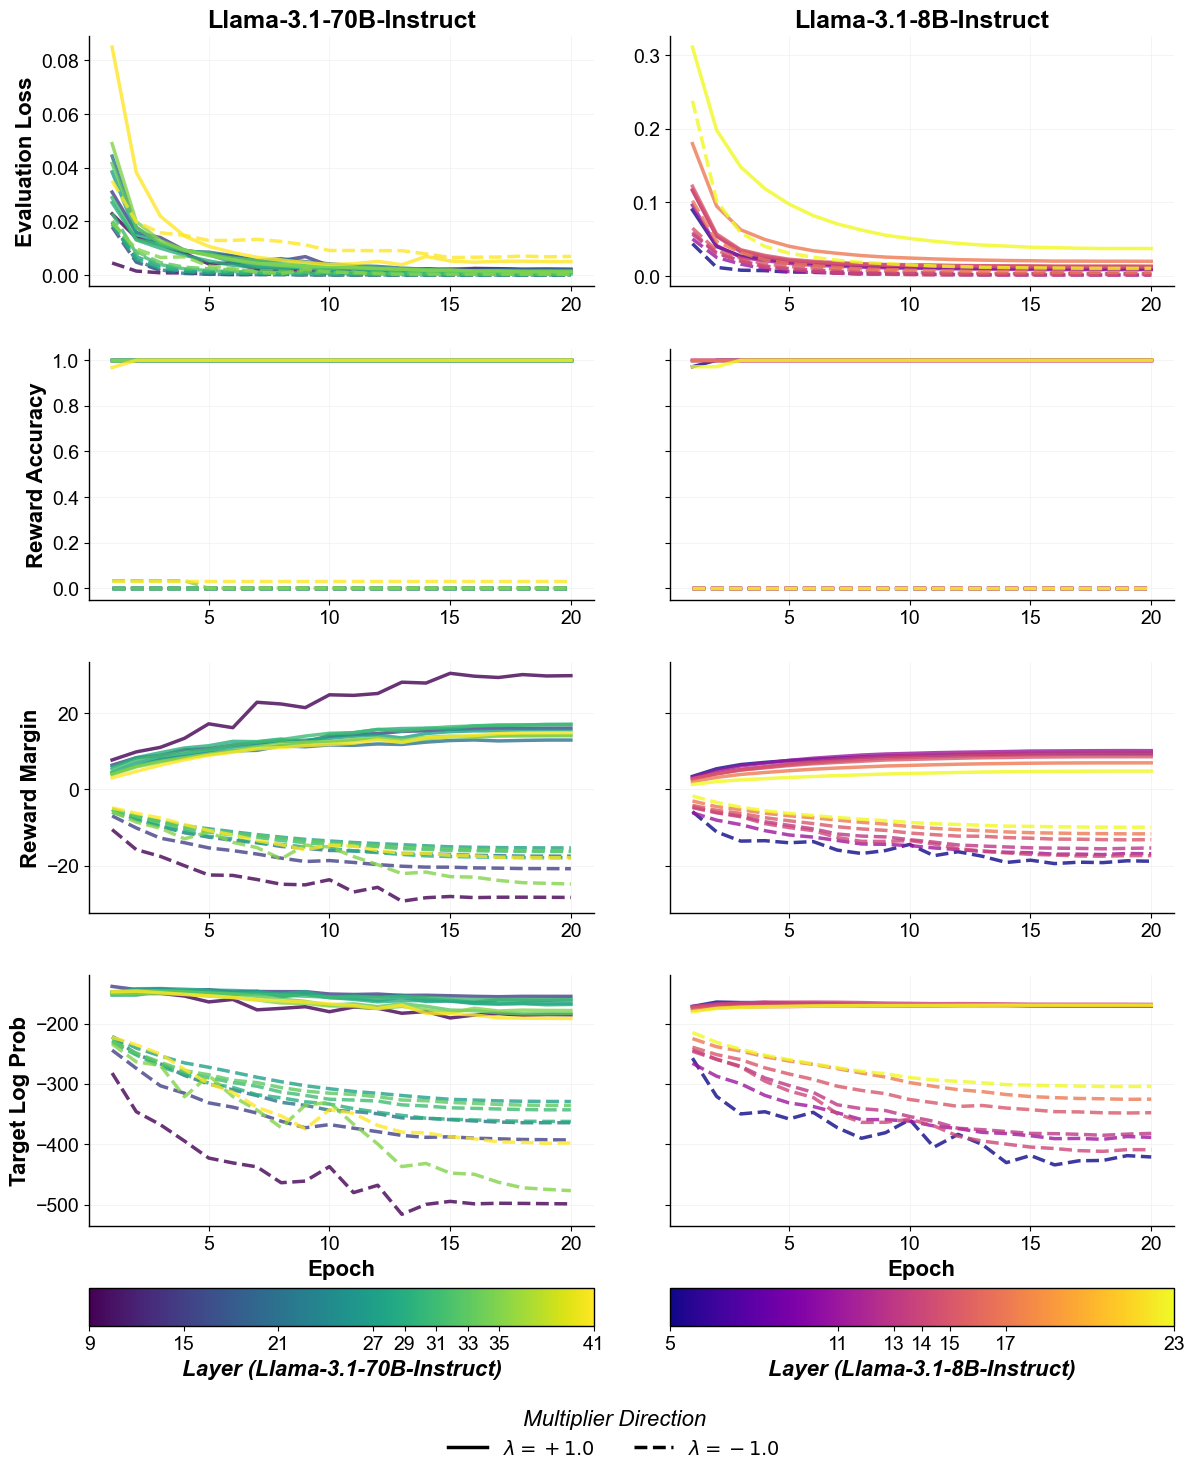

In [5]:
fig = plot_training_dynamics(data, figsize=(14, 15))
save_fig(fig, FIGURE_DIR, "training_dynamics")
plt.show()

## Summary Statistics

In [6]:
# Summary table of final epoch metrics
summary_rows = []

for key, store in data.items():
    df = store["losses"]
    meta = store["metadata"]

    # Get final epoch for positive multiplier
    final = df[(df["epoch"] == df["epoch"].max()) & (df["eval_multiplier"] == 1.0)]

    if len(final) > 0:
        row = final.iloc[0]
        summary_rows.append(
            {
                "Model": meta["model"],
                "Layer": meta["layer"],
                "Final Epoch": int(row["epoch"]),
                "Reward Accuracy": row.get("eval_rewards/accuracies", np.nan),
                "Reward Margin": row.get("eval_rewards/margins", np.nan),
                "Target Log Prob": row.get("eval_logps/chosen", np.nan),
            }
        )

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(["Model", "Layer"])
print(summary_df.to_string(index=False))

                 Model  Layer  Final Epoch  Reward Accuracy  Reward Margin  Target Log Prob
Llama-3.1-70B-Instruct      9           20              1.0      29.750042      -185.434494
Llama-3.1-70B-Instruct     15           20              1.0      16.018532      -154.911819
Llama-3.1-70B-Instruct     21           20              1.0      12.890712      -160.890518
Llama-3.1-70B-Instruct     27           20              1.0      15.420102      -166.939743
Llama-3.1-70B-Instruct     29           20              1.0      17.010738      -168.230103
Llama-3.1-70B-Instruct     31           20              1.0      16.963026      -160.436035
Llama-3.1-70B-Instruct     33           20              1.0      14.155467      -183.333725
Llama-3.1-70B-Instruct     35           20              1.0      14.002242      -178.355484
Llama-3.1-70B-Instruct     41           20              1.0      14.816437      -191.523468
 Llama-3.1-8B-Instruct      5           20              1.0       9.328458      

## Generation Metrics (Perplexity & Propensity)

These metrics are computed from model generations at different multiplier strengths.

In [7]:
def load_generation_metrics(epoch=20, silent=False):
    """Load generation metrics (perplexity, propensity) for all model-layer combinations."""
    gen_data = {}

    for model_name, n_layers in SHORT_MODELS.items():
        layers = LAYER_CONFIGS[n_layers]["layers"]

        for layer in layers:
            key = f"{model_name}-layer{layer}"
            gen_file = (
                VECTOR_EVALS_DIR
                / model_name
                / f"layer{layer}"
                / f"generations_ep{epoch}.jsonl"
            )

            if gen_file.exists():
                with open(gen_file, "r") as f:
                    df = pd.read_json(StringIO(f.read()), lines=True)
                gen_data[key] = df
                if not silent:
                    print(f"Loaded {len(df)} generations for {key}")
            else:
                if not silent:
                    print(f"Missing: {gen_file}")
    return gen_data

In [8]:
# Count of generation entries per model-layer
total_count = 0
for epoch in [10, 15, 20]:
    epoch_count = 0
    gen_data = load_generation_metrics(epoch=epoch, silent=True)
    for key, df in gen_data.items():
        total_count += len(df)
        epoch_count += len(df)
    print(
        f"\nAt epoch {epoch}, loaded generation data for {len(gen_data)} model-layer combinations"
    )
    print(f"Total generation entries at epoch {epoch}: {epoch_count}")


print(f"\nTotal generation entries across all model-layers-epochs: {total_count}")


At epoch 10, loaded generation data for 16 model-layer combinations
Total generation entries at epoch 10: 82320

At epoch 15, loaded generation data for 9 model-layer combinations
Total generation entries at epoch 15: 46305

At epoch 20, loaded generation data for 16 model-layer combinations
Total generation entries at epoch 20: 82320

Total generation entries across all model-layers-epochs: 210945


In [9]:
# This notebook will use epoch 20 generation data
gen_data = load_generation_metrics(epoch=20, silent=False)
print(f"\nLoaded generation data for {len(gen_data)} model-layer combinations")

Loaded 5145 generations for Llama-3.1-70B-Instruct-layer9
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer15
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer21
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer27
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer29
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer31
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer33
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer35
Loaded 5145 generations for Llama-3.1-70B-Instruct-layer41
Loaded 5145 generations for Llama-3.1-8B-Instruct-layer5
Loaded 5145 generations for Llama-3.1-8B-Instruct-layer11
Loaded 5145 generations for Llama-3.1-8B-Instruct-layer13
Loaded 5145 generations for Llama-3.1-8B-Instruct-layer14
Loaded 5145 generations for Llama-3.1-8B-Instruct-layer15
Loaded 5145 generations for Llama-3.1-8B-Instruct-layer17
Loaded 5145 generations for Llama-3.1-8B-Instruct-layer23

Loaded generation data for 16 model-layer combinations


In [10]:
def plot_perplexity_propensity_grid(
    gen_data,
    model="Llama-3.1-70B-Instruct",
    full_range=(-20, 20),
    narrow_range=(-2, 2),
    figsize=(16, 16),
):
    """
    Plot perplexity and propensity for all layers with full and narrow ranges.

    Layout: Layers as rows, 4 columns (perp-full, perp-narrow, prop-full, prop-narrow)
    """
    # Get model configuration
    n_layers = SHORT_MODELS[model]
    layers = LAYER_CONFIGS[n_layers]["layers"]

    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(len(layers), 4, hspace=0.3, wspace=0.2)

    axes = []
    for row in range(len(layers)):
        row_axes = []
        perp_ax = None
        prop_ax = None

        for col in range(4):
            if col == 0:
                ax = fig.add_subplot(gs[row, col])
                perp_ax = ax
            elif col == 1:
                ax = fig.add_subplot(gs[row, col], sharey=perp_ax)
            elif col == 2:
                ax = fig.add_subplot(gs[row, col])
                prop_ax = ax
            else:
                ax = fig.add_subplot(gs[row, col], sharey=prop_ax)
            row_axes.append(ax)
        axes.append(row_axes)

    # Metric labels
    metric_labels = {
        "perplexity": r"Log$_{10}$(Perplexity)",
        "propensity": "Propensity",
    }

    # Colors from Pastel2
    colors = {
        ("perplexity", "full"): PASTEL2[0],
        ("perplexity", "narrow"): PASTEL2[0],
        ("propensity", "full"): PASTEL2[1],
        ("propensity", "narrow"): PASTEL2[1],
    }

    for row_idx, layer in enumerate(layers):
        data_key = f"{model}-layer{layer}"

        cols_config = [
            ("perplexity", "full", 0, full_range),
            ("perplexity", "narrow", 1, narrow_range),
            ("propensity", "full", 2, full_range),
            ("propensity", "narrow", 3, narrow_range),
        ]

        for metric, range_type, col_idx, multiplier_range in cols_config:
            ax = axes[row_idx][col_idx]
            color = colors[(metric, range_type)]

            try:
                metric_data = gen_data[data_key].copy()
                metric_data = metric_data.rename(columns={metric: "score"})

                if metric == "perplexity":
                    metric_data["score"] = np.log10(metric_data["score"])

                # Filter by multiplier range
                metric_data = metric_data[
                    (metric_data["multiplier"] >= multiplier_range[0])
                    & (metric_data["multiplier"] <= multiplier_range[1])
                ]

                # Aggregate
                grouped = (
                    metric_data.groupby("multiplier")["score"]
                    .agg(["mean", "std"])
                    .reset_index()
                )
                x_values = grouped["multiplier"]
                y_values = grouped["mean"]
                y_err = grouped["std"]

                # Plot with error bands
                ax.plot(
                    x_values,
                    y_values,
                    marker="o",
                    color=color,
                    linewidth=2,
                    markersize=4,
                )
                ax.fill_between(
                    x_values, y_values - y_err, y_values + y_err, alpha=0.3, color=color
                )

                # Styling
                ax.set_xlim(multiplier_range)

                # Special styling for narrow range columns
                if range_type == "narrow":
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_linestyle(":")
                        spine.set_linewidth(2)
                        spine.set_edgecolor("darkgray")
                    ax.set_facecolor("#fafafa")
                    ax.tick_params(labelleft=False)

                # Highlight narrow range region in full plots
                if range_type == "full":
                    y_min, y_max = ax.get_ylim()
                    rect = Rectangle(
                        (narrow_range[0], y_min),
                        narrow_range[1] - narrow_range[0],
                        y_max - y_min,
                        linewidth=2,
                        edgecolor="darkgray",
                        facecolor="#fafafa",
                        linestyle=":",
                        alpha=0.7,
                        zorder=1,
                    )
                    ax.add_patch(rect)

                # Column titles (only on top row)
                if row_idx == 0:
                    range_label = r"$\lambda$ = [%d, %d]" % (
                        multiplier_range[0],
                        multiplier_range[1],
                    )
                    title = f"{metric_labels[metric]}\n{range_label}"
                    ax.set_title(title)

                # Row labels (only on leftmost column)
                if col_idx == 0:
                    ax.set_ylabel(f"Layer {layer}")

            except Exception as e:
                ax.text(
                    0.5,
                    0.5,
                    "No data",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    color="gray",
                )
                ax.set_xlim(multiplier_range)

    # X-axis label on bottom row
    for col_idx in range(4):
        axes[-1][col_idx].set_xlabel(r"Multiplier ($\lambda$)")

    plt.suptitle(
        f"Perplexity and Propensity ({model})",
        fontweight="bold",
    )
    plt.tight_layout()

    return fig

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_45509/1994914073.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: perplexity_propensity_70B


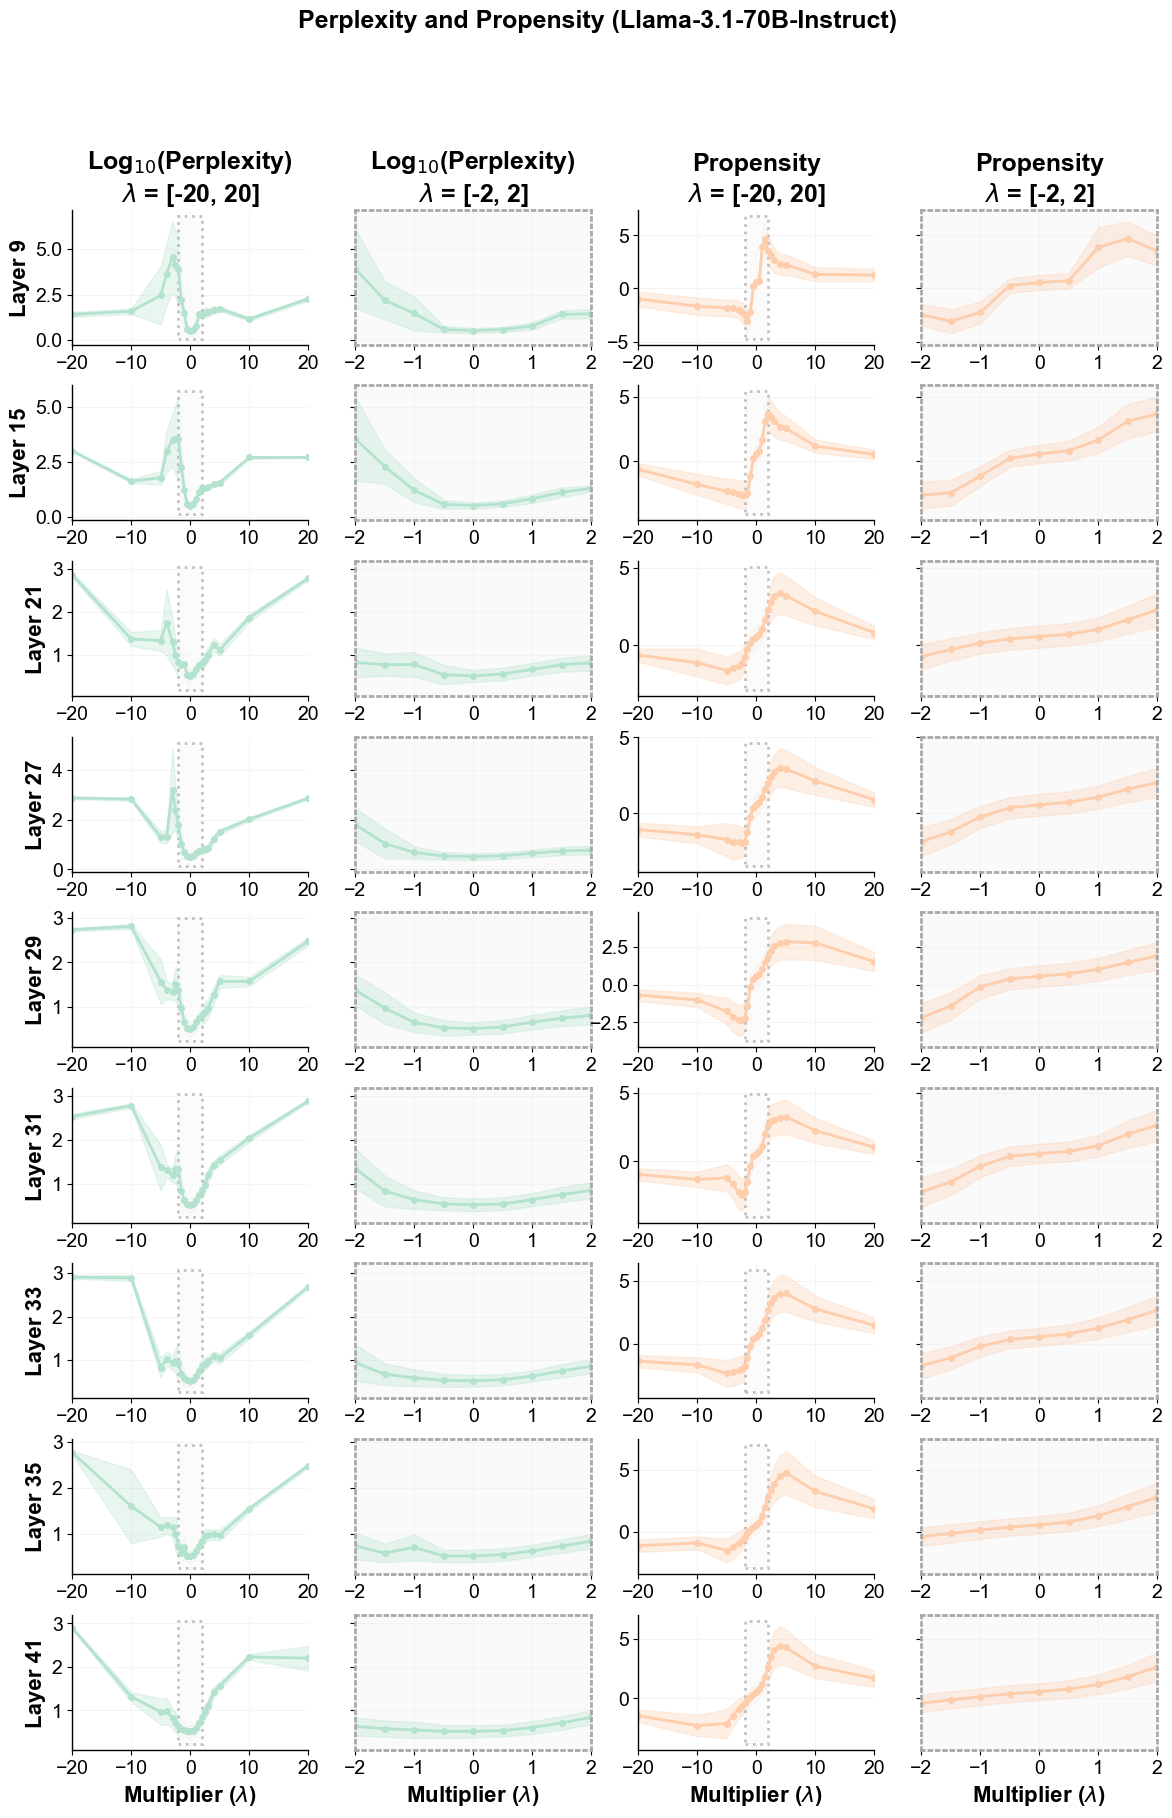

In [11]:
# Plot for 70B model
fig_70b = plot_perplexity_propensity_grid(
    gen_data,
    model="Llama-3.1-70B-Instruct",
    full_range=(-20, 20),
    narrow_range=(-2, 2),
    figsize=(14, 20),
)
save_fig(fig_70b, FIGURE_DIR, "perplexity_propensity_70B")
plt.show()

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_45509/1994914073.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: perplexity_propensity_8B


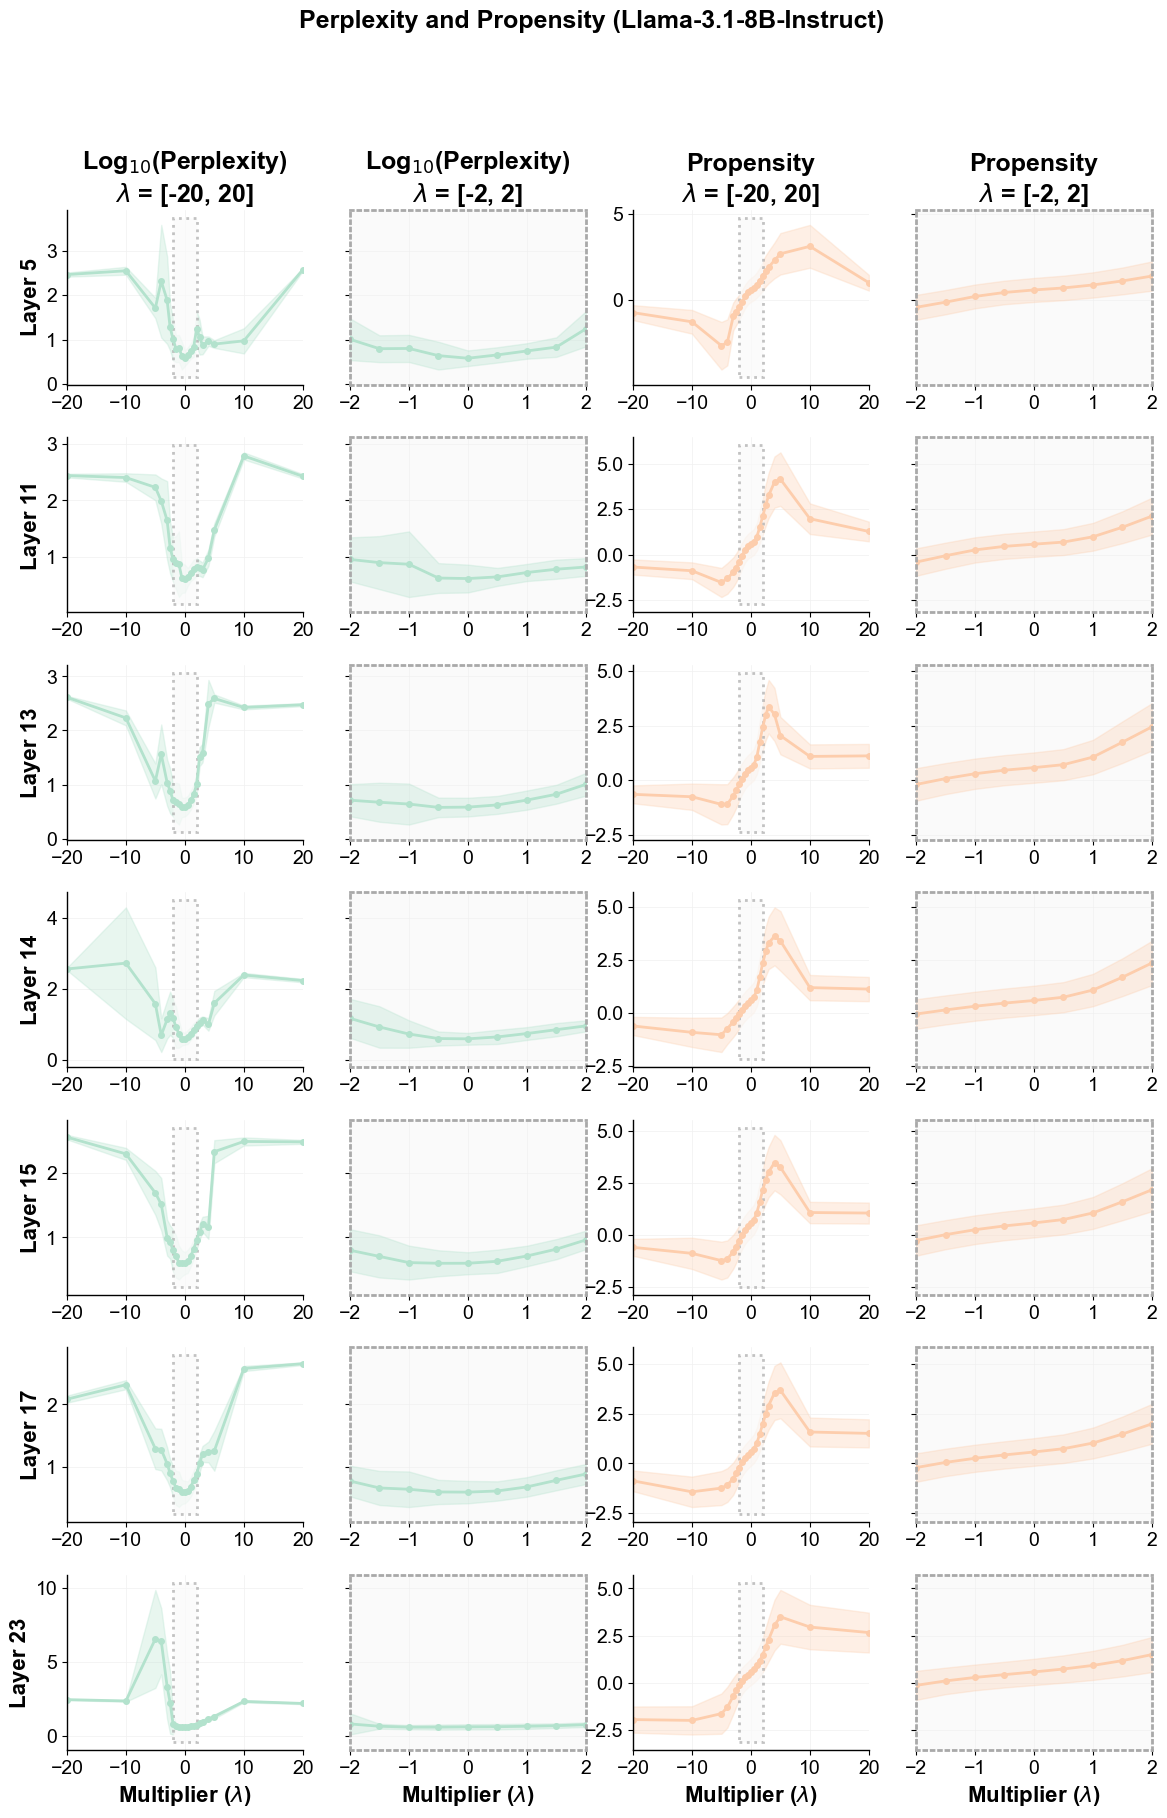

In [12]:
# Plot for 8B model
fig_8b = plot_perplexity_propensity_grid(
    gen_data,
    model="Llama-3.1-8B-Instruct",
    full_range=(-20, 20),
    narrow_range=(-2, 2),
    figsize=(14, 20),
)
save_fig(fig_8b, FIGURE_DIR, "perplexity_propensity_8B")
plt.show()